# This notebook provides interactive widgets to play with the imaging requirements for the SKA1 SDP

## First, do the necessary set-up (run this code block first)

In [1]:
'''
The following commands import the python modules, methods and code fragments that are required to run this notebook. 
Please refer to the following python files for implementation details (omitted here for readability)
* env_setup.py -- code for setting up the python environment
* parameter_definitions.py -- contains definitions of variables, primary telescope parameters  
* formulae.py -- contains formulae for defiving secondary telescope-specific parameters from input parameters
* implementation.py -- contains methods for performing computations (i.e. crunching the numbers)
'''

from IPython.html.widgets import interact, interactive, fixed
from IPython.html.widgets.interaction import interact_manual
from IPython.html import widgets
from IPython.display import clear_output, display, HTML

from env_setup import *
from parameter_definitions import *
from formulae import *
from implementation import Implementation as imp
from api import SKAAPI as api

# Important block: this defines the available telescopes, bands and modes that a user may choose from.

available_teles = (Telescopes.SKA1_Low, Telescopes.SKA1_Mid, Telescopes.SKA1_Low_old, Telescopes.SKA1_Mid_old, 
                   Telescopes.SKA1_Sur_old, Telescopes.SKA2_Low, Telescopes.SKA2_Mid)
available_bands = (Bands.Low, Bands.Mid1, Bands.Mid2, Bands.Sur1)
available_modes = (ImagingModes.Continuum, ImagingModes.Spectral, ImagingModes.SlowTrans)


def show_table(header, titles, values, units):
    s = '<h3>%s:</h3><table>\n' % header
    assert len(titles) == len(values)
    assert len(titles) == len(units)
    for i in range(len(titles)):
        s += '<tr><td>{0}</td><td><font color="blue">{1}</font> {2}</td></tr>\n'.format(titles[i], values[i], units[i])
    s += '</table>'
    display(HTML(s))
    
def evaluate_expressions(expressions, tp, Tsnap, Nfacet):
    """
    Evaluate a sequence of expressions by substituting the telescope_parameters into them. Returns the result
    """    
    results = []
    for expression in expressions:
        expression_subst = -1
        try:
            expression_subst = expression.subs({tp.Tsnap : Tsnap, tp.Nfacet : Nfacet})
            result = imp.evaluate_binned_expression(expression_subst, tp)
        except Exception as e:
            result = expression
            
        results.append(result)
    return results

def compute_flops_subset(max_baseline, Nf_max, Nfacet, Tsnap, Telescope, Band, Mode):      
    # First we plot a table with all the provided parameters
    param_titles = ('Max Baseline', 'Max # of channels', 'Telescope', 'Band', 'Mode', 'Tsnap', 'Nfacet')
    param_values = (max_baseline, Nf_max, Telescope, Band, Mode, Tsnap, Nfacet)
    param_units = ('km', '', '', '', '', 'sec', '')
    show_table('Arguments', param_titles, param_values, param_units)
    
    if not api.telescope_and_band_are_compatible(Telescope, Band):
        msg = 'ERROR: Telescope and Band are not compatible'
        s = '<font color="red"><b>{0}</b>.<br>Adjust to recompute.</font>'.format(msg)
        display(HTML(s))
    else:
        # And now the results:
        tp = imp.calc_tel_params(Telescope, Mode, band=Band)  # Calculate the telescope parameters        
        max_allowed_baseline = tp.baseline_bins[-1] / u.km    
        if max_baseline <= max_allowed_baseline:
            tp.Bmax = max_baseline * u.km
            tp.Nf_max = Nf_max
            imp.update_derived_parameters(tp, mode=Mode)
            # The result expressions need to be defined here as they depend on tp (updated in the line above)
            result_expressions = (tp.Mbuf_vis/u.peta, tp.Mw_cache/u.tera, tp.Npix_linear, tp.Rio/u.tera, 
                                  tp.Rflop/u.peta)
            result_titles = ('Visibility Buffer', 'Working (cache) memory', 'Image side length', 'I/O Rate', 
                             'Total Compute Requirement')
            result_units = ('PetaBytes', 'TeraBytes', 'pixels', 'TeraBytes/s','PetaFLOPS')
            result_values = evaluate_expressions(result_expressions, tp, Tsnap, Nfacet)
            result_value_string = []
            for i in range(len(result_values)):
                expression = result_expressions[i]
                if expression is not tp.Npix_linear: 
                    result_value_string.append('%.3g' % result_values[i])
                else:
                    result_value_string.append('%d' % result_values[i])

            show_table('Computed Values', result_titles, result_value_string, result_units)
        else :
            msg = 'ERROR: max_baseline exceeds the maximum allowed baseline of %g km for this telescope.' \
                % max_allowed_baseline
            s = '<font color="red"><b>{0}</b>.<br>Adjust to recompute.</font>'.format(msg)
            display(HTML(s))

def compute_flops_full(max_baseline, Nf_max, Telescope, Band, Mode):
    # First we plot a table with all the provided parameters
    param_titles = ('Max Baseline', 'Max # of channels', 'Telescope', 'Band', 'Mode')
    param_values = (max_baseline, Nf_max, Telescope, Band, Mode)
    param_units = ('km', '', '', '', '')
    show_table('Arguments', param_titles, param_values, param_units)
    
    if not api.telescope_and_band_are_compatible(Telescope, Band):
        msg = 'ERROR: Telescope and Band are not compatible'
        s = '<font color="red"><b>{0}</b>.<br>Adjust to recompute.</font>'.format(msg)
        display(HTML(s))
    else:
        # And now the results:
        display(HTML('<font color="blue">Computing the result -- this may take several (tens of) seconds.</font>'))
        tp = imp.calc_tel_params(Telescope, Mode, band=Band)  # Calculate the telescope parameters        
        max_allowed_baseline = tp.baseline_bins[-1] / u.km    
        if max_baseline <= max_allowed_baseline:
            tp.Bmax = max_baseline * u.km
            tp.Nf_max = Nf_max
            imp.update_derived_parameters(tp, Mode)
            (Tsnap, Nfacet) = imp.find_optimal_Tsnap_Nfacet(tp, verbose=True)

            # The result expressions need to be defined here as they depend on tp (updated in the line above)
            result_expressions = (tp.Mbuf_vis/u.peta, tp.Mw_cache/u.tera, tp.Npix_linear, tp.Rio/u.tera, 
                                  tp.Rflop/u.peta, tp.Rflop_grid/u.peta, tp.Rflop_fft/u.peta, tp.Rflop_proj/u.peta, 
                                  tp.Rflop_conv/u.peta, tp.Rflop_phrot/u.peta)
            result_titles = ('Number of Facets', 'Snapshot Time', 'Visibility Buffer', 'Working (cache) memory', 
                             'Image side length', 'I/O Rate', 'Total Compute Requirement', 
                             'rflop_grid', 'rflop_fft', 'rflop_proj', 'rflop_conv', 'rflop_phrot')
            result_units = ('', 'sec.', 'PetaBytes', 'TeraBytes', 'pixels', 'TeraBytes/s','PetaFLOPS',
                            'PetaFLOPS','PetaFLOPS','PetaFLOPS','PetaFLOPS','PetaFLOPS')

            result_value_string = []
            result_value_string.append('%d' % Nfacet)
            result_value_string.append('%.3g' % Tsnap)
            result_values = evaluate_expressions(result_expressions, tp, Tsnap, Nfacet)
            for i in range(len(result_values)):
                expression = result_expressions[i]
                if expression is not tp.Npix_linear: 
                    result_value_string.append('%.3g' % result_values[i])
                else:
                    result_value_string.append('%d' % result_values[i])

            show_table('Computed Values', result_titles, result_value_string, result_units)
            plot_flops('FLOP breakdown for %s' % Telescope, result_values[5], 
                       result_values[6], result_values[7], result_values[8], result_values[9])
        else :
            msg = 'ERROR: max_baseline exceeds the maximum allowed baseline of %g km for this telescope.' % max_allowed_baseline
            s = '<font color="red"><b>{0}</b>.<br>Adjust to recompute.</font>'.format(msg)
            display(HTML(s))
        
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pylab as pylab

def plot_flops(title, rflop_grid, rflop_fft, rflop_proj, rflop_conv, rflop_phrot):
    pylab.rcParams['figure.figsize'] = 8, 6  # that's default image size for this interactive session

    values = [rflop_grid, rflop_fft, rflop_proj, rflop_conv, rflop_phrot]

    # The slices will be ordered and plotted counter-clockwise.
    labels = '(de)Gridding', '(i)FFT', '(Re)Projection', 'Convolution', 'Phrot'
    colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral', 'green']
    explode = (0.05, 0.05, 0.05, 0.05, 0.05) # Radial offset of the slices

    plt.pie(values, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=90)
    # Set aspect ratio to be equal so that pie is drawn as a circle.
    plt.axis('equal')
    plt.title('%s\n' % title)

    plt.show()

:0: FutureWarning: IPython widgets are experimental and may change in the future.

IPython console for SymPy 0.7.5 (Python 2.7.9-64-bit) (ground types: python)


Hook shutdown_hook is deprecated. Use the atexit module instead.


## Now, we can interactively play with parameters

### The first option is automatic updating of results as the sliders are moved. This may be sluggish

In [7]:
interact(compute_flops_subset, max_baseline=(0,200,10), Nf_max = (0,256000,16000), Nfacet=(1,10,1), Tsnap=(1.2,1800), 
         Telescope=available_teles, Band=available_bands, Mode=available_modes);

Max Baseline,70 km
Max # of channels,128000
Telescope,SKA1Low_rebaselined
Band,Low
Mode,Continuum
Tsnap,900.6 sec
Nfacet,5


NOT IMPLEMENTING BASELINE DEPENDENT TIME AVERAGING
Tdump_predict = 0.6*s
Tdump_backward = Min(60.0*s, 0.6*N_facet*s)
NOT IMPLEMENTING BASELINE DEPENDENT TIME AVERAGING
Tdump_predict = 0.6*s
Tdump_backward = Min(60.0*s, 0.6*N_facet*s)


Visibility Buffer,1.11 PetaBytes
Working (cache) memory,1.26 TeraBytes
Image side length,46814 pixels
I/O Rate,7.07 TeraBytes/s
Total Compute Requirement,4.47 PetaFLOPS


### The second option is manual triggering of recompute events (recommended). 

**This allows more conveniently computing elaborate (slow) optimizations and visualizations per computation, as these are only run when required**

Max Baseline,80 km
Max # of channels,64000
Telescope,SKA1Low_rebaselined
Band,Low
Mode,Spectral


NOT IMPLEMENTING BASELINE DEPENDENT TIME AVERAGING
Tdump_predict = 0.6*s
Tdump_backward = Min(60.0*s, 0.6*N_facet*s)
NOT IMPLEMENTING BASELINE DEPENDENT TIME AVERAGING
Tdump_predict = 0.6*s
Tdump_backward = Min(60.0*s, 0.6*N_facet*s)
Evaluating Nfacets = 1
Tsnap has been optimized as : 108.662906. (Cost function = 2.753615)
Evaluating Nfacets = 2
Tsnap has been optimized as : 189.954494. (Cost function = 2.570453)
Evaluating Nfacets = 3
Tsnap has been optimized as : 238.240589. (Cost function = 3.666379)

Expression increasing with number of facets; aborting exploration of Nfacets > 3

2.570453 PetaFLOPS was the lowest FLOP value, found for (Nfacet, Tsnap) = (2, 189.95)


Number of Facets,2
Snapshot Time,190 sec.
Visibility Buffer,28.9 PetaBytes
Working (cache) memory,1.37 TeraBytes
Image side length,74308 pixels
I/O Rate,6.7 TeraBytes/s
Total Compute Requirement,2.57 PetaFLOPS
rflop_grid,0.504 PetaFLOPS
rflop_fft,0.368 PetaFLOPS
rflop_proj,0.279 PetaFLOPS
rflop_conv,1.4 PetaFLOPS


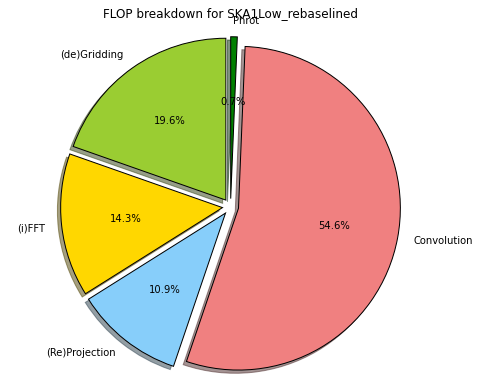

In [6]:
# In this example, Tsnap and Nfacet are *automatically* chosen so as to minimize the value of Rflop

interact_manual(compute_flops_full, max_baseline=(0,200,10), Nf_max = (0,256000,32000), Telescope=available_teles, 
         Band=available_bands, Mode=available_modes);